In [57]:
import pandas as pd
fp = "canada_fires.csv"
full_data = pd.read_csv(fp, dtype=str)

In [71]:
full_data.columns

Index(['WKT', 'SRC_AGENCY', 'FIRE_ID', 'FIRENAME', 'LATITUDE', 'LONGITUDE',
       'YEAR', 'MONTH', 'DAY', 'REP_DATE', 'ATTK_DATE', 'OUT_DATE', 'DECADE',
       'SIZE_HA', 'CAUSE', 'PROTZONE', 'FIRE_TYPE', 'CFS_REF_ID', 'ACQ_DATE',
       'SRC_AGY2', 'ECOZONE', 'ECOZ_REF', 'ECOZ_NAME'],
      dtype='object')

In [2]:
p = pd.to_numeric(df_train['SIZE_HA'])
t = list(p)
for x in t:
    if  0:
        get_min = min(get_min, x)
print(get_min)

NameError: name 'df_train' is not defined

In [58]:
'''
I remove:
WKT,
FIRE_ID,
FIRENAME,
SRC_AGENCY, LATITUDE, LONGITUDE, as we have Zones,
DAY may not be as important as year and months
I don't know what's ATTK_DATE but it's always NaN when out_date is NaN. So it's not helpful in prediction.
we use DECADE instead of YEAR
I don't know whats ACQ_DATE but it seems to be not related.
I don't use PROTZONE for now [Whats that? It may be good to be used.]
CFS_REF_ID,'SRC_AGY2', 'ECOZ_REF', 'ECOZ_NAME'

'''
df = full_data[["MONTH", "REP_DATE", "OUT_DATE", "DECADE", "SIZE_HA", "CAUSE", "FIRE_TYPE",  "ECOZONE"]]
df = df.fillna('NaN')


In [5]:
df.head()

,MONTH,REP_DATE,OUT_DATE,DECADE,SIZE_HA,CAUSE,FIRE_TYPE,ECOZONE
0,7,7/5/1970,NaN,1970-1979,1173.6,H,NaN,5
1,6,6/18/1968,NaN,1960-1969,404.69,L,NaN,5
2,7,7/25/1967,NaN,1960-1969,404.1,L,NaN,5
3,6,6/29/1967,NaN,1960-1969,1252.1,L,NaN,5
4,9,9/11/1967,NaN,1960-1969,1279.6,L,NaN,5


In [103]:
set(list(df["FIRE_TYPE"].values))

{'1',
 '2',
 '3',
 '4',
 'Crown',
 'Dump',
 'Fire',
 'Forest',
 'Grass',
 'Ground',
 'IFR',
 'Mutual Aid',
 'NaN',
 'OFR',
 'Other',
 'Prescribed Burn',
 'Req For Assist',
 'Request For Ass*',
 'Surface',
 'Type 1',
 'Type 2',
 'Type 3',
 'Type 4',
 'Type 5',
 'Wildfire'}

In [148]:
df_train = df[(df['OUT_DATE'] != "NaN") & (df['REP_DATE'] != "NaN")]

df_train[['REP_DATE','OUT_DATE']] = df_train[['REP_DATE','OUT_DATE']].apply(pd.to_datetime) #if conversion required
df_train['duration_days'] = (df_train['OUT_DATE'] - df_train['REP_DATE']).dt.days
df_train = df_train.drop(['OUT_DATE', 'REP_DATE'],axis = 1)
df_train.to_csv("before_encode.csv")

/Users/melika/anaconda3/envs/myenv/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/melika/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [149]:
import numpy as np
df = full_data[["MONTH", "REP_DATE", "OUT_DATE", "DECADE", "SIZE_HA", "CAUSE", "FIRE_TYPE",  "ECOZONE"]]
df = df.fillna('NaN')

df['SIZE_HA'] = pd.to_numeric(df['SIZE_HA'])

df['SIZE_HA']=df['SIZE_HA'].replace(0,0.000001)
df['SIZE_HA'] = np.log10(df['SIZE_HA']).astype(int)
df = df.rename(columns = {"SIZE_HA" : "SIZE_HA_log"})

set(list(df["SIZE_HA_log"].values))

{-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6}

In [82]:

# One hot month => We do not have NaN in months so one_hot would be enough
one_hot = pd.get_dummies(df['MONTH'])
one_hot = one_hot.rename(columns = {'0': 'month_0', '1': 'month_1', '2': 'month_2',
                                   '3': 'month_3', '4': 'month_4', '5': 'month_5',
                                    '6': 'month_6', '7':'month_7', '8': 'month_8',
                                    '9': 'month_9', '10': 'month_10', '11': 'month_11',
                                    '12': 'month_12'                   
                                   })

one_hot
df = df.drop('MONTH',axis = 1)
df = df.join(one_hot)

#ONE HOT CAUSE

one_hot = pd.get_dummies(df['CAUSE'])
one_hot.drop('NaN', axis=1, inplace=True) #NaN values encoding
one_hot = one_hot.rename(columns = {
    "H" : "cause_H",
    "H-PB": "cause_PB",
    "L": "cause_L",
    "RE": "cause_RE",
    "U": "cause_U"
})
df = df.drop('CAUSE',axis = 1)
df = df.join(one_hot)

# ONE HOT DECADE 
one_hot = pd.get_dummies(df['DECADE'])
df = df.drop('DECADE',axis = 1)
df = df.join(one_hot)

# Fire TYPE
one_hot = pd.get_dummies(df['FIRE_TYPE'])
one_hot.drop('NaN', axis=1, inplace=True) #NaN values encoding
df = df.drop('FIRE_TYPE',axis = 1)
df = df.join(one_hot)

In [24]:
df_train.head()

,MONTH,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE,duration_days
5,7,2010-2019,3,L,NaN,5,24
6,7,2010-2019,0,L,NaN,5,17
7,7,2010-2019,1,L,NaN,5,17
8,7,2010-2019,0,L,NaN,6,3
9,7,2010-2019,0,L,NaN,6,3


In [52]:
df_train.head()

,MONTH,DECADE,SIZE_HA,CAUSE,FIRE_TYPE,ECOZONE,duration_days
5,7,2010-2019,1009.5,L,NaN,5,24
6,7,2010-2019,5.2,L,NaN,5,17
7,7,2010-2019,16.5,L,NaN,5,17
8,7,2010-2019,8.7,L,NaN,6,3
9,7,2010-2019,2.6,L,NaN,6,3


In [150]:
df_test = df[(df['OUT_DATE'] == "NaN") | (df['REP_DATE'] == "NaN")]
df_train = df[(df['OUT_DATE'] != "NaN") & (df['REP_DATE'] != "NaN")]
df_test = df_test.drop(['OUT_DATE', 'REP_DATE'],axis = 1)

print(df_train.shape, df_test.shape)

(208772, 8) (204376, 6)


In [151]:
df_train[['REP_DATE','OUT_DATE']] = df_train[['REP_DATE','OUT_DATE']].apply(pd.to_datetime) #if conversion required
df_train['duration_days'] = (df_train['OUT_DATE'] - df_train['REP_DATE']).dt.days
df_train = df_train.drop(['OUT_DATE', 'REP_DATE'],axis = 1)

#it's just warning. It's ok!

/Users/melika/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
df.head()

,MONTH,REP_DATE,OUT_DATE,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE
0,7,7/5/1970,NaN,1970-1979,3,H,NaN,5
1,6,6/18/1968,NaN,1960-1969,2,L,NaN,5
2,7,7/25/1967,NaN,1960-1969,2,L,NaN,5
3,6,6/29/1967,NaN,1960-1969,3,L,NaN,5
4,9,9/11/1967,NaN,1960-1969,3,L,NaN,5


In [152]:
import matplotlib.pyplot as plt
df_train['duration_days'] = pd.to_numeric(df_train['duration_days'])
print(df_train.shape)
sizes = df_train[(df_train["duration_days"]<50)]

#plt.hist(sizes)
print(sizes.shape)

(208772, 7)
(203485, 7)


In [153]:
#df.loc[df['duration_days'] < 0 , 'duration_days'] = -10 #Error
df_train = df_train[~(df_train['duration_days'] < 0)] #remove error
df_train.loc[df_train['duration_days'] > 10, 'duration_days'] = -1 #large
df_train.loc[df_train['duration_days'] >= 0, 'duration_days'] = 0
df_train.loc[df_train['duration_days'] == -1, 'duration_days'] = 1
#df.loc[df['duration_days'] > 5, 'duration_days'] = -2 #Med
#df.loc[df['duration_days'] > 2, 'duration_days'] = -3 #Med Low
#df.loc[df['duration_days'] == 2, 'duration_days'] = 2 #2
#df.loc[df['duration_days'] == 1, 'duration_days'] = 1 #1
#df.loc[df['duration_days'] == 0, 'duration_days'] = 0 #0

In [14]:
df.head()

,MONTH,REP_DATE,OUT_DATE,DECADE,SIZE_HA,CAUSE,FIRE_TYPE,ECOZONE
0,7,7/5/1970,NaN,1970-1979,3,H,NaN,5
1,6,6/18/1968,NaN,1960-1969,2,L,NaN,5
2,7,7/25/1967,NaN,1960-1969,2,L,NaN,5
3,6,6/29/1967,NaN,1960-1969,3,L,NaN,5
4,9,9/11/1967,NaN,1960-1969,3,L,NaN,5


In [29]:
df_test.to_csv("test_data.csv")

In [17]:
df_train.head()

,REP_DATE,OUT_DATE,SIZE_HA_log,ECOZONE,month_0,month_1,month_10,month_11,month_12,month_2,...,Prescribed Burn,Req For Assist,Request For Ass*,Surface,Type 1,Type 2,Type 3,Type 4,Type 5,Wildfire
5,7/27/2019,8/20/2019,3,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7/27/2019,8/13/2019,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7/27/2019,8/13/2019,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,7/27/2019,7/30/2019,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,7/27/2019,7/30/2019,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df_train.head()

,MONTH,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE,duration days greater than 10 days
5,7,2010s,3,L,NaN,5,1
6,7,2010s,0,L,NaN,5,1
7,7,2010s,1,L,NaN,5,1
8,7,2010s,0,L,NaN,6,0
9,7,2010s,0,L,NaN,6,0


In [140]:
print(commutes)

       MONTH     DECADE  SIZE_HA_log CAUSE FIRE_TYPE ECOZONE  duration_days
5          7  2010-2019            3     L       NaN       5             24
6          7  2010-2019            0     L       NaN       5             17
7          7  2010-2019            1     L       NaN       5             17
8          7  2010-2019            0     L       NaN       6              3
9          7  2010-2019            0     L       NaN       6              3
...      ...        ...          ...   ...       ...     ...            ...
409302     8  1990-1999            0     L       NaN       4              2
409304     7  2010-2019            2     L       NaN       4             23
409305     6  2010-2019            3     L       NaN       4             28
409306     6  2010-2019            2     L       NaN       4             27
409308     6  2010-2019            0     L       NaN       4             14

[203005 rows x 7 columns]


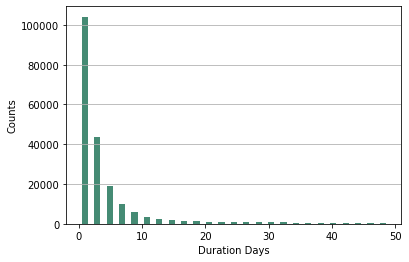

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate data on commute times.
size, scale = 10, 10
commutes = df_train[(df_train['duration_days']>=0) & (df_train['duration_days']<50) ]['duration_days']# & (df_train['duration_days']<50)]

commutes.plot.hist(grid=False, bins=25, rwidth=0.5,
                   color='#458B74')
#plt.title('Histogram of duration days for less than 50 days')
plt.xlabel('Duration Days')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)
plt.savefig('days11.png')


In [132]:
commutes = df_train[(df_train['duration_days']>=0)]
new_df = commutes
#XX= new_df['duration_days']
new_df['duration_days']

5         24
6         17
7         17
8          3
9          3
          ..
409304    23
409305    28
409306    27
409307    50
409308    14
Name: duration_days, Length: 208292, dtype: int64

In [27]:

stats_df = new_df \
.groupby('duration_days') \
['duration_days'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'duration_days': 'frequency'})

In [28]:
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['frequency'].cumsum()
stats_df = stats_df.reset_index()
stats_df

,duration_days,frequency,pdf,cdf
0,0,56959,0.273524,56959
1,1,47161,0.226473,104120
2,2,26917,0.129259,131037
3,3,16887,0.081094,147924
4,4,11223,0.053894,159147
...,...,...,...,...
253,286,1,0.000005,208236
254,287,1,0.000005,208237
255,288,1,0.000005,208238
256,291,2,0.000010,208240


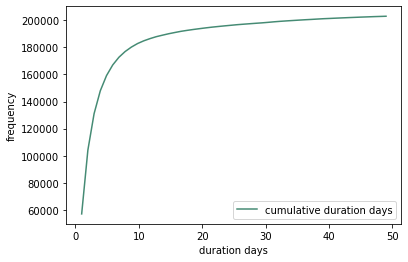

In [138]:
#stats_df.plot.bar(x = 'duration_days', y = ['cdf'], grid = False)

#bins = [0,0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#df2 = stats_df.groupby(pd.cut(stats_df['cdf'], bins=bins)).cdf.count()
#df2.plot(kind='bar')
import numpy as np
new_df = new_df[new_df['duration_days'] < 50]
count, bins_count = np.histogram(new_df['duration_days'], bins=50)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(count)
plt.xlabel("duration days")
plt.ylabel("frequency")
# plotting PDF and CDF
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="cumulative duration days", color='#458B74')
plt.legend()
plt.savefig("dur.png")

In [65]:
#commutes = commutes.map({'1940-1949': '1940s', '1950-1959': '1950s', '1960-1969': '1960s', '1970-1979':'1970s',
#                              '1980-1989': '1980s', '1990-1999':'1990s', '2000-2009':'2000s',
#                              '2010-2019':'2010s', '2020-2029':'2020s', '2020-2019':'NaN'
#                              })

df_train['DECADE'] = df_train['DECADE'].map({'1940-1949': '1940s', '1950-1959': '1950s', '1960-1969': '1960s', '1970-1979':'1970s',
                              '1980-1989': '1980s', '1990-1999':'1990s', '2000-2009':'2000s',
                              '2010-2019':'2010s', '2020-2029':'2020s', '2020-2019':'NaN'
                              })

In [100]:
#commutes = df_train['MONTH'].astype(int)
commutes = df_train['CAUSE']


In [69]:
g

,MONTH,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE,duration_days
5,7,2010s,3,L,NaN,5,1
6,7,2010s,0,L,NaN,5,1
7,7,2010s,1,L,NaN,5,1
8,7,2010s,0,L,NaN,6,0
9,7,2010s,0,L,NaN,6,0
...,...,...,...,...,...,...,...
409304,7,2010s,2,L,NaN,4,1
409305,6,2010s,3,L,NaN,4,1
409306,6,2010s,2,L,NaN,4,1
409307,7,2010s,0,L,NaN,4,1


{0: 56959, 1: 47161, 2: 26917, 3: 16887, 4: 11223, 5: 7861, 6: 5710, 7: 4224, 8: 3266, 9: 2631, 10: 2007, 11: 1630, 12: 1419, 13: 1109, 14: 1064, 15: 922, 16: 883, 17: 715, 18: 655, 19: 598, 20: 581, 21: 537, 22: 473, 23: 454, 24: 430, 25: 437, 26: 356, 27: 346, 28: 338, 29: 318, 30: 378, 31: 418, 32: 354, 33: 312, 34: 286, 35: 289, 36: 277, 37: 240, 38: 277, 39: 258, 40: 194, 41: 211, 42: 201, 43: 198, 44: 181, 45: 190, 46: 162, 47: 175, 48: 143, 49: 150}


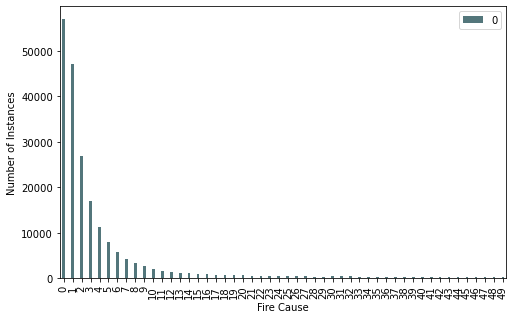

In [137]:
from collections import Counter
commutes = new_df[new_df['duration_days'] < 50]['duration_days']



letter_counts = Counter(commutes)
letter_counts = dict(sorted(letter_counts.items()))
print(letter_counts)
dffff = pd.DataFrame.from_dict(letter_counts, orient='index')



fig = dffff.plot(kind='bar',width=0.,  color='#53767B', 
        figsize=(8, 5), fontsize=10, grid = False)

fig.set_xlabel("Fire Cause")
fig.set_ylabel("Number of Instances")

fig = fig.get_figure()
fig.savefig('cause.png')
#dffff.plot(kind='bar', color='#53868B')



In [118]:
from collections import Counter


import pandas as pd
import matplotlib.pyplot as plt

# Generate data on commute times.
size, scale = 10, 10
commutes = df_train['MONTH'].astype(int)
letter_counts = Counter(commutes)
letter_counts = dict(sorted(letter_counts.items()))
dffff = pd.DataFrame.from_dict(letter_counts, orient='index')
print(dffff)
fig = dffff.plot(kind='bar',width=0.3,  color='#53767B',  grid = True,
#        figsize=(8, 5), fontsize=10).get_figure()#plt.xlabel('Duration Days')
#plt.ylabel('Counts')
#plt.grid(axis='y', alpha=1)
#plt.savefig('days2.png')
#fig.savefig('size.png')



        0
1     329
2     279
3    1299
4   18358
5   44155
6   41622
7   47057
8   37380
9   11790
10   4475
11   1247
12    301


In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate data on commute times.
size, scale = 10, 10
x = sorted(list(df_train['SIZE_HA']))
dd = [float(a) for a in x]
res = []
for g in dd:
    if g < 10:
        res.append(g)

print(len(res))        
#import numpy as np
#import seaborn as sns
#sns.set_style('whitegrid')

#fig = sns.kdeplot(np.array(res), bw=0.5,  color='#53767B').get_figure()
#fig.savefig("size2.png") 

185286


In [84]:
print(h)

       MONTH DECADE  SIZE_HA_log CAUSE FIRE_TYPE ECOZONE  \
5          7  2010s            3     L       NaN       5   
6          7  2010s            0     L       NaN       5   
7          7  2010s            1     L       NaN       5   
8          7  2010s            0     L       NaN       6   
9          7  2010s            0     L       NaN       6   
...      ...    ...          ...   ...       ...     ...   
409304     7  2010s            2     L       NaN       4   
409305     6  2010s            3     L       NaN       4   
409306     6  2010s            2     L       NaN       4   
409307     7  2010s            0     L       NaN       4   
409308     6  2010s            0     L       NaN       4   

        duration days greater than 10 days  
5                                        1  
6                                        1  
7                                        1  
8                                        0  
9                                        0  
...      

SEASON                              1)WINTER  2)SPRING  3)SUMMER    4)FALL
duration days greater than 10 days                                        
0                                   0.002645  0.323291  0.589053  0.085011
1                                   0.017914  0.172865  0.732534  0.076687


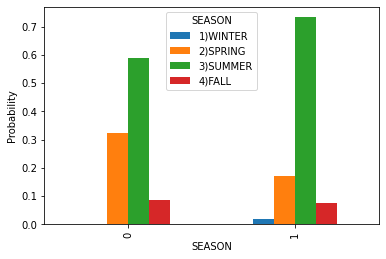

In [156]:
#################################################
# Cross tabulation between GENDER and APPROVE_LOAN
h = df_train
h.columns = h.columns.str.replace('duration_days', 'duration days greater than 10 days')

CrosstabResult=pd.crosstab(index=h['duration days greater than 10 days'],columns=h['SEASON'], normalize='index')
print(CrosstabResult)


# Grouped bar chart between GENDER and APPROVE_LOAN
fig = CrosstabResult.plot.bar()
fig.set_xlabel("SEASON")
fig.set_ylabel("Probability")
fig.figure.savefig('normalses.png')

In [126]:
df_train.head()

,MONTH,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE,duration days greater than 10 days,SEASON
5,7,2010s,3,L,NaN,5,1,3)SUMMER
6,7,2010s,0,L,NaN,5,1,3)SUMMER
7,7,2010s,1,L,NaN,5,1,3)SUMMER
8,7,2010s,0,L,NaN,6,0,3)SUMMER
9,7,2010s,0,L,NaN,6,0,3)SUMMER


CAUSE                                      H      H-PB         L       NaN  \
duration days greater than 10 days                                           
0                                   0.593624  0.000227  0.386592  0.000481   
1                                   0.262305  0.001791  0.727587  0.001578   

CAUSE                                     RE         U  
duration days greater than 10 days                      
0                                   0.000346  0.018729  
1                                   0.000427  0.006312  


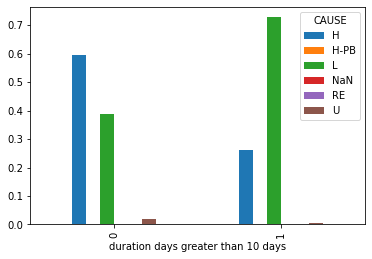

In [133]:

CrosstabResult=pd.crosstab(index=df_train['duration days greater than 10 days'],columns=df_train['SEASON'], normalize='index')
print(CrosstabResult)

# Grouped bar chart between GENDER and APPROVE_LOAN
fig = CrosstabResult.plot.bar()
fig.figure.savefig('normalized_cause.png')

In [155]:
def normalise_row(row):
    if row['MONTH'] == '5' or row['MONTH'] == '4' or  row['MONTH'] == '3':
        return "2)SPRING"

    if row['MONTH'] == '12' or row['MONTH'] == '1' or  row['MONTH'] == '2':
        return "1)WINTER"


    if row['MONTH'] == '6' or row['MONTH'] == '7' or  row['MONTH'] == '8':
        return "3)SUMMER"


    if row['MONTH'] == '11' or row['MONTH'] == '10' or  row['MONTH'] == '9':
        return "4)FALL"



df_train['SEASON'] = df_train.apply(lambda row : normalise_row(row), axis=1) 

In [40]:
df_train.dtypes

MONTH            object
DECADE           object
SIZE_HA_log       int64
CAUSE            object
FIRE_TYPE        object
ECOZONE          object
duration_days     int64
SEASON           object
dtype: object

In [139]:
commutes = df_train[(df_train['MONTH'])]# & (df_train['duration_days']<50)]



KeyError: "None of [Index(['7', '7', '7', '7', '7', '6', '6', '6', '6', '6',\n       ...\n       '6', '6', '6', '8', '7', '7', '6', '6', '7', '6'],\n      dtype='object', length=208292)] are in the [columns]"

In [146]:
df_train.head()

,MONTH,DECADE,SIZE_HA_log,CAUSE,FIRE_TYPE,ECOZONE,duration days greater than 10 days,SEASON
5,7,2010-2019,3,L,NaN,5,24,3)SUMMER
6,7,2010-2019,0,L,NaN,5,17,3)SUMMER
7,7,2010-2019,1,L,NaN,5,17,3)SUMMER
8,7,2010-2019,0,L,NaN,6,3,3)SUMMER
9,7,2010-2019,0,L,NaN,6,3,3)SUMMER


<AxesSubplot:ylabel='Frequency'>

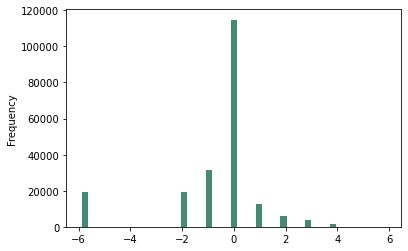

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate data on commute times.
size, scale = 10, 10
commutes = df_train['SIZE_HA_log']# & (df_train['duration_days']<50)]

commutes.plot.hist(grid=False, bins=25, rwidth=0.5,
                   color='#458B74')
#plt.title('Histogram of duration days for less than 50 days')
#new_df = commutes['SIZE_HA_log']


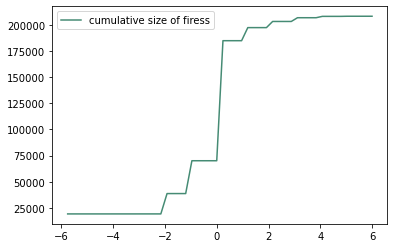

In [146]:
#stats_df.plot.bar(x = 'duration_days', y = ['cdf'], grid = False)

#bins = [0,0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#df2 = stats_df.groupby(pd.cut(stats_df['cdf'], bins=bins)).cdf.count()
#df2.plot(kind='bar')
import numpy as np
count, bins_count = np.histogram(commutes, bins=50)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(count)
  
# plotting PDF and CDF
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="cumulative size of firess", color='#458B74')
plt.legend()
plt.savefig("cum_size.png")

In [23]:
import pandas as pd
fp = "/Users/melika/Documents/MScProject/FireData/run_all/results.csv"
df = pd.read_csv(fp, names=['source', 'target', 'cp', 'd', 'od', 'count', 'total', 'd-ratio'], header=None)


In [21]:
df.head()

,id,source,target,cp,d,od,count,total,d-ratio
0,9,10,0.157834,0.236034,0.236034,151,47835,0.003157,NaN
1,6,14,0.052378,0.038115,0.038115,0,174465,0.000000,NaN
2,14,12,3.734340,1.924744,2.096228,1695,57150,0.029659,NaN
3,12,4,1.363488,1.424627,1.388935,0,378810,0.000000,NaN
4,5,9,1.152865,0.540953,0.708577,0,2440665,0.000000,NaN


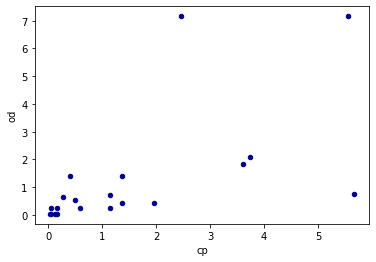

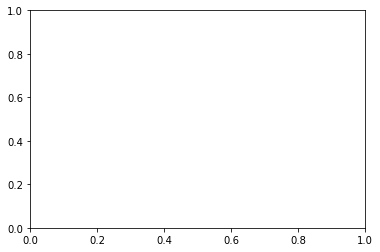

In [25]:
df.plot.scatter(x='cp',
                 y='od',
                   c='DarkBlue')


In [26]:
import matplotlib.pyplot as plt


import numpy as np
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)


In [29]:
df['ind'] = df.index 

In [31]:
df.head()

,source,target,cp,d,od,count,total,d-ratio,ind
0,9,10,0.157834,0.236034,0.236034,151,47835,0.003157,0
1,6,14,0.052378,0.038115,0.038115,0,174465,0.000000,1
2,14,12,3.734340,1.924744,2.096228,1695,57150,0.029659,2
3,12,4,1.363488,1.424627,1.388935,0,378810,0.000000,3
4,5,9,1.152865,0.540953,0.708577,0,2440665,0.000000,4


<AxesSubplot:xlabel='cp', ylabel='od'>

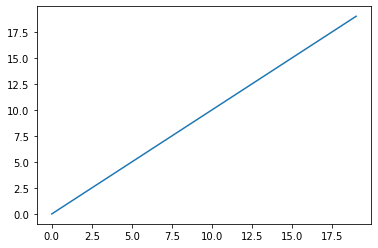

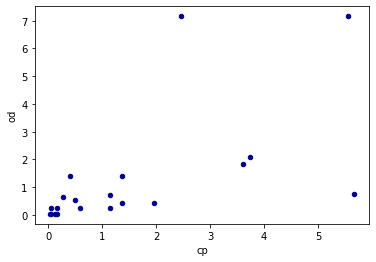

In [33]:
df['ind'].plot.line()
df.plot.scatter(x='cp',
                 y='od',
                   c='DarkBlue')



In [35]:
plt.plot(df['cp'], df['od'], label='A', color='green')



AttributeError: 'function' object has no attribute 'scatter'

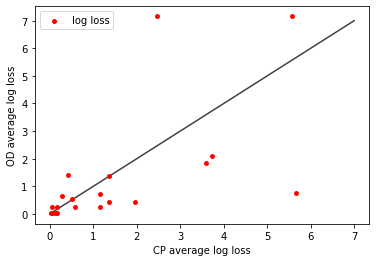

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df['cp'], df['od'], s=15, c='r', label='log loss')
ax1.plot(p, p, 'k-', alpha=0.75, zorder=0)
plt.xlabel("CP average log loss")
plt.ylabel("OD average log loss")
plt.legend(loc='upper left');
plt.show()
plt.savefig("logloss1.png")

In [44]:
p = list(range(8))

In [19]:
import pandas as pd
fp = "/Users/melika/Documents/MScProject/FireData/run_all/soph_models2.csv"
df = pd.read_csv(fp)



In [2]:
df.head()

,source_pop,target_pop,LR,LR-O,LR-OD,XGB,XGB-D,XGB-OD
0,9,10,0.624844,0.641436,0.631380,0.531681,0.539789,0.5350982544918449
1,4,9,0.377503,0.379068,0.378632,0.413892,0.414885,0.4147515458029093
2,9,14,0.169863,0.169882,0.159163,0.145303,0.156820,0.14302649169951767
3,9,6,0.382641,0.383148,0.383088,0.358179,0.358727,0.35865592180333555
4,5,9,0.386253,0.403595,0.391753,0.414714,0.414102,0.4164643721372517


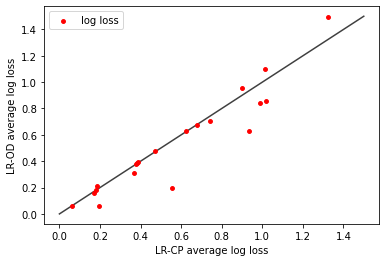

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
p = [0, 1.5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df['LR'], df['LR-OD'], s=15, c='r', label='log loss')
ax1.plot(p, p, 'k-', alpha=0.75, zorder=0)
plt.xlabel("LR-CP average log loss")
plt.ylabel("LR-OD average log loss")
plt.legend(loc='upper left');
plt.show()
plt.savefig("lr.png")

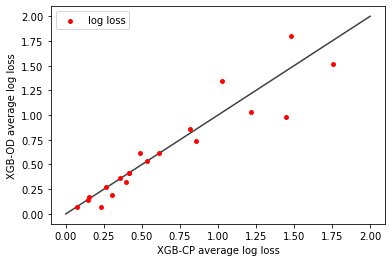

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
p = list(range(3))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(p, p, 'k-', alpha=0.75, zorder=0)
df['XGB']= df['XGB'].astype(float)
df['XGB-OD']= df['XGB-OD'].astype(float)


ax1.scatter(df['XGB'], df['XGB-OD'], s=15, c='r', label='log loss')


plt.xlabel("XGB-CP average log loss")
plt.ylabel("XGB-OD average log loss")
plt.legend(loc='upper left');
plt.show()
plt.savefig("xgb.png")

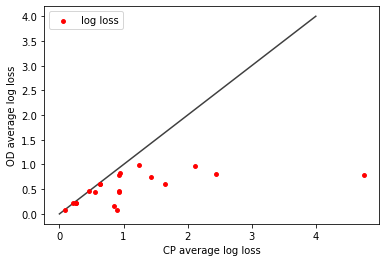

<Figure size 432x288 with 0 Axes>

In [8]:
import pandas as pd
fp = "/Users/melika/Documents/MScProject/FireData/run_all/results2.csv"
df = pd.read_csv(fp, names=['source', 'target', 'cp', 'd', 'od', 'count', 'total', 'd-ratio'], header=None)
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
p = list(range(5))


ax1.scatter(df['cp'], df['od'], s=15, c='r', label='log loss')
ax1.plot(p, p, 'k-', alpha=0.75, zorder=0)
plt.xlabel("CP average log loss")
plt.ylabel("OD average log loss")
plt.legend(loc='upper left');
plt.show()
plt.savefig("truelogloss.png")




In [21]:
import pandas as pd
fp = "/Users/melika/Documents/MScProject/Stroke/stroke_soph.csv"
df = pd.read_csv(fp)


df.head()

,split,source,target,lrc,lrd,lrod,xgbc,xgbd,xgbod
0,Male,0,1,0.006268,0.004996,0.004562,0.004318,0.000461,0.004442
1,Male,1,0,0.003436,0.014223,0.005910,0.003745,0.014842,0.003835
2,Rural,0,1,0.014557,0.021006,0.015226,0.007517,0.013994,0.007638
3,Rural,1,0,0.003406,0.003189,0.003459,0.001080,0.000542,0.001076
4,Yes,1,0,0.005013,0.001536,0.006792,0.000485,0.000970,0.001140


In [22]:
print("ok")

ok


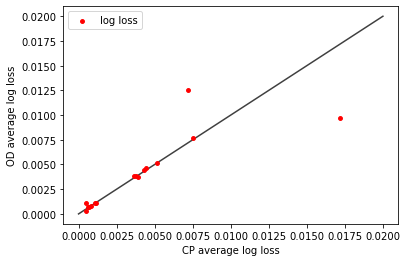

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
p = [x/100 for x in range(3)]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(p, p, 'k-', alpha=0.75, zorder=0)
#df['XGB']= df['XGB'].astype(float)
#df['XGB-OD']= df['XGB-OD'].astype(float)


ax1.scatter(df['xgbc'], df['xgbod'], s=15, c='r', label='log loss')


plt.xlabel("CP average log loss")
plt.ylabel("OD average log loss")
plt.legend(loc='upper left');
plt.show()
plt.savefig("stroke-lr.png")